<a href="https://colab.research.google.com/github/naenumtou/creditrisk/blob/main/scoringEvaluationMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style

In [3]:
# Import final score development
scoreDev = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/creditrisk/main/datasets/scoreDevelopment.csv'
)

# Show
scoreDev

,Band,N,Bad
0,B9,173402,5782
1,B8,363116,4366
2,B7,558965,3110
3,B6,1167112,2212
4,B5,1089056,876
5,B4,871794,326
6,B3,709425,137
7,B2,600909,87
8,B1,264135,18


## Model classification ability
The quality of a scorecard depends crucially on its ability to successfully distinguish good and bad accounts. These set of tests help in assessing the performance of the scorecard at the validation sample level. The test would be used to decide the further follow-up action required based on the output of the tests.

### Accuracy Ratio
This test validates the scorecard at a portfolio level by computation of the **AUC** and **GINI**. This measure captures the discriminatory power of the scorecard and its ability to correctly identify the good accounts from the bad accounts.
The value of this ratio is between 0% (completely random model) and 100% (totally perfect model). Given the final score bands and their corresponding final good/bad distributions, the AUC/GINI are calculated as below:

\begin{align}
        \text{%Cumulative good} = \frac{\text{Goods until corresponding scoreband}}{\text{Total number of goods}}
    \end{align}

\begin{align}
    \text{%Cumulative bad} = \frac{\text{Bads until corresponding scoreband}}{\text{Total number of bads}}
\end{align}

\begin{align}
        \text{AUC}_{pool, i} = \frac{1}{2} * (\text{%Cum good}_{i} - \text{%Cum good}_{i - 1}) * (\text{%Cum bad}_{i} + \text{%Cum bad}_{i-1})
    \end{align}

Then, the AUC of portfolio level is:

\begin{align}
        \text{AUC} = \sum\text{AUC}_{pool, i}
    \end{align}

The GINI can be derived from AUC as:
\begin{align}
        \text{GINI} = \text{2 * AUC - 1}
    \end{align}

### Kolmogorov-Smirnov Statistic
This test validates the scorecard at a portfolio level by computation of the Kolmogorov-Smirnov (KS) statistic. This measure explores the difference between the good and bad rates among all the score bands. It is used in combination with the Gini/Accuracy Ratio to assess the quality of the scorecard.
The KS statistic is computed as the maximum difference between the good rate and the bad rate among all the score bands:

\begin{align}
        \text{KS} = max(| \text{%Cum good}_{i} - \text{%Cum bad}_{i} |) 
    \end{align}

In [4]:
# Define function model classification ability
def modelClass(df):
  table = df.copy()
  table['Good'] = table['N'] - table['Bad']
  table['badRate'] = table['Bad'] / table['N']
  table['goodRate'] = table['Good'] / table['N']
  table['%Bad'] = table['Bad'] / table['Bad'].sum()
  table['%Good'] = table['Good'] / table['Good'].sum()
  table['cumBadFreq'] = table['%Bad'].cumsum()
  table['cumGoodFreq'] = table['%Good'].cumsum()
  table['BGOdds'] = table['Bad'].cumsum() / table['Good'].cumsum()
  table['GBOdds'] = table['Good'].cumsum() / table['Bad'].cumsum()
  table['cumBad'] = table['Bad'].cumsum() / table['Bad'].sum()
  table['cumGood'] = table['Good'].cumsum() / table['Good'].sum()
  ROC = []
  for i in range(table.shape[0]):
    data = table[['cumBad', 'cumGood']].values
    if i == 0:
      roc = -0.5 * (0 - data[i][1]) * (0 + data[i][0])
      ROC.append(roc)
    else:
      roc = -0.5 * (data[i - 1][1] - data[i][1]) * (data[i - 1][0] + data[i][0])
      ROC.append(roc)  
  table['ROC'] = ROC
  table['KS'] = abs(table['cumGood'] - table['cumBad'])
  return table

# Apply function
classDevResult = modelClass(scoreDev)
classDevResult

,Band,N,Bad,Good,badRate,goodRate,%Bad,%Good,cumBadFreq,cumGoodFreq,BGOdds,GBOdds,cumBad,cumGood,ROC,KS
0,B9,173402,5782,167620,0.033344,0.966656,0.341847,0.028995,0.341847,0.028995,0.034495,28.989969,0.341847,0.028995,0.004956,0.312852
1,B8,363116,4366,358750,0.012024,0.987976,0.258129,0.062057,0.599976,0.091052,0.019279,51.869334,0.599976,0.091052,0.029223,0.508925
2,B7,558965,3110,555855,0.005564,0.994436,0.183871,0.096152,0.783848,0.187204,0.012251,81.628074,0.783848,0.187204,0.066529,0.596644
3,B6,1167112,2212,1164900,0.001895,0.998105,0.130779,0.201505,0.914627,0.388709,0.006884,145.256949,0.914627,0.388709,0.171126,0.525918
4,B5,1089056,876,1088180,0.000804,0.999196,0.051791,0.188234,0.966418,0.576943,0.004901,204.044109,0.966418,0.576943,0.177038,0.389476
5,B4,871794,326,871468,0.000374,0.999626,0.019274,0.150747,0.985692,0.727690,0.003963,252.325636,0.985692,0.727690,0.147137,0.258003
6,B3,709425,137,709288,0.000193,0.999807,0.008100,0.122693,0.993792,0.850382,0.003419,292.466000,0.993792,0.850382,0.121434,0.143410
7,B2,600909,87,600822,0.000145,0.999855,0.005144,0.103930,0.998936,0.954313,0.003063,326.520064,0.998936,0.954313,0.103553,0.044623
8,B1,264135,18,264117,0.000068,0.999932,0.001064,0.045687,1.000000,1.000000,0.002926,341.787868,1.000000,1.000000,0.045663,0.000000


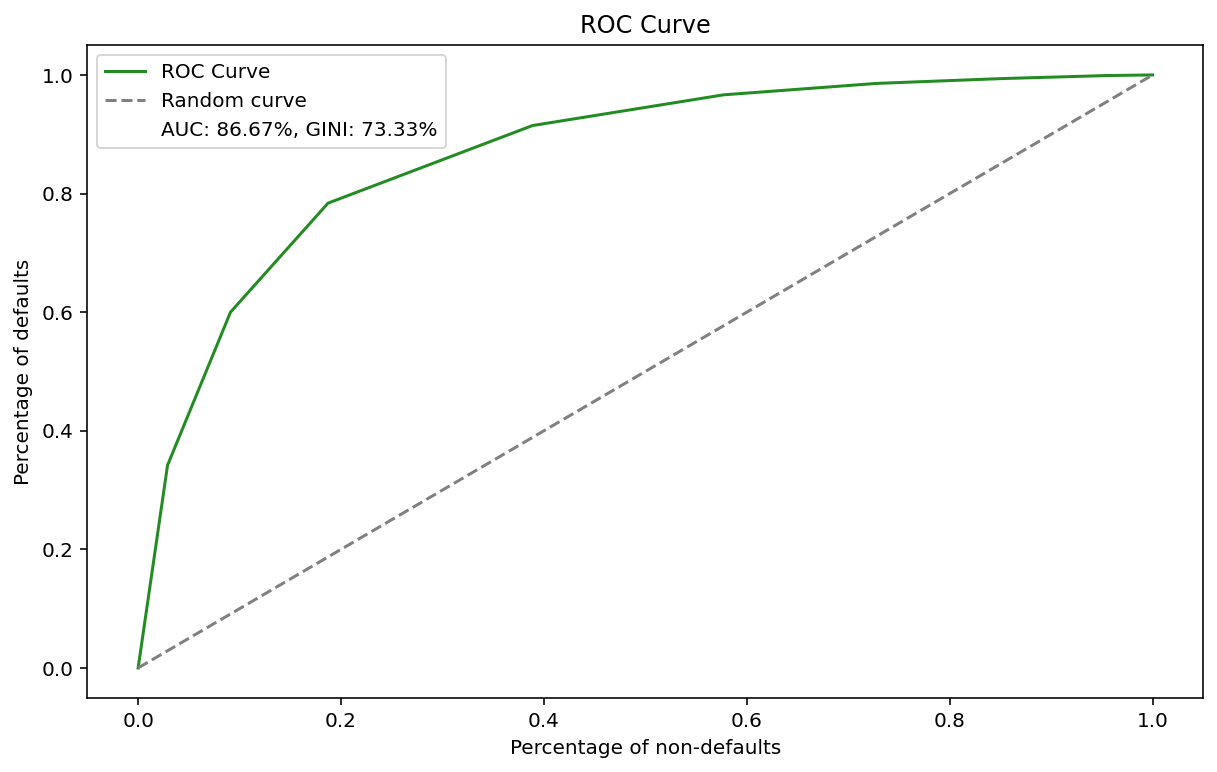

In [5]:
# Classification ability
AUC = classDevResult['ROC'].sum()
GINI = AUC * 2 - 1
KS = classDevResult['KS'].max()

# Plot
# ROC
plt.figure(figsize = (10, 6))
plt.plot(
    np.hstack((0, classDevResult['cumGood'])),
    np.hstack((0, classDevResult['cumBad'])),
    c = 'forestgreen',
    label = 'ROC Curve'
)
plt.plot(
    [0, 1],
    [0, 1],
    c = 'gray',
    linestyle = '--',
    label = 'Random curve'
)
plt.plot([], [], ' ', label = f'AUC: {AUC * 100:.2f}%, GINI: {GINI * 100:.2f}%')
plt.title('ROC Curve')
plt.xlabel('Percentage of non-defaults')
plt.ylabel('Percentage of defaults')
plt.legend(frameon = True, facecolor = 'white')
plt.show()

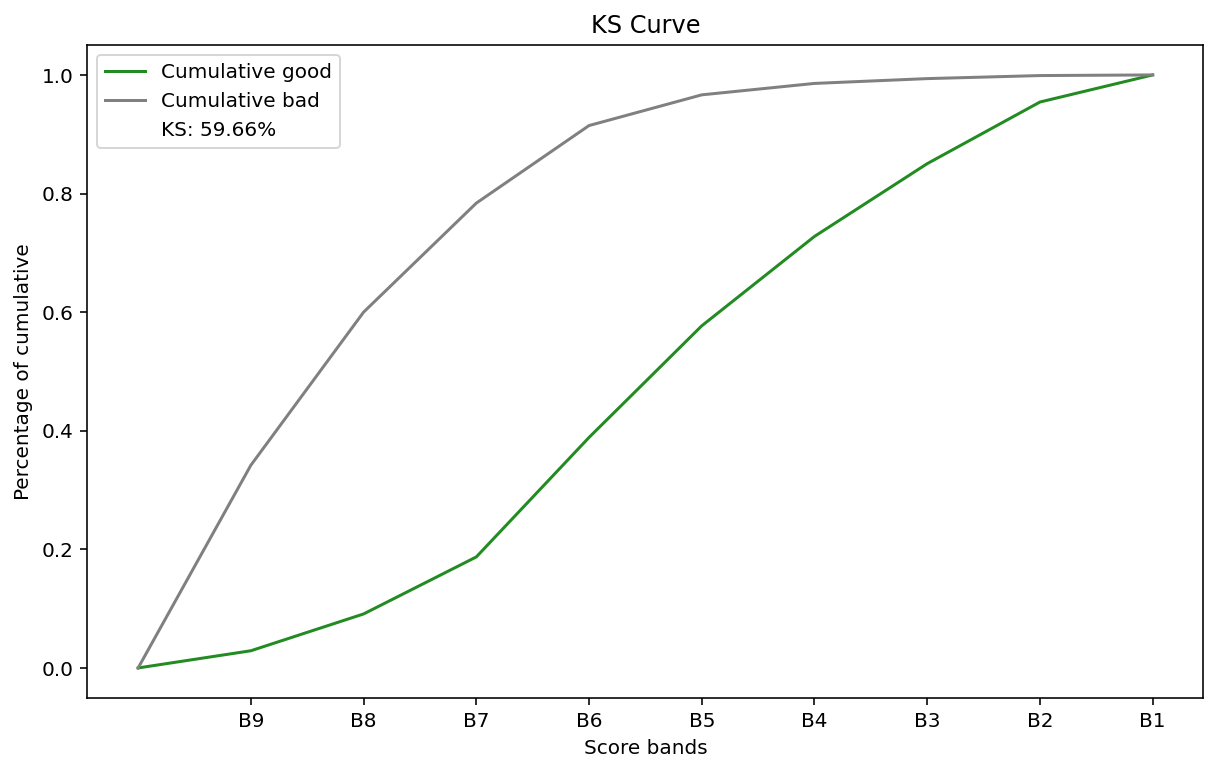

In [6]:
# Plot
# KS
plt.figure(figsize = (10, 6))
plt.plot(
    np.hstack((0, classDevResult['cumGood'])),
    c = 'forestgreen',
    label = 'Cumulative good'
)
plt.plot(
    np.hstack((0, classDevResult['cumBad'])),
    c = 'gray',
    label = 'Cumulative bad'
)
plt.plot([], [], ' ', label = f'KS: {KS * 100:.2f}%')
plt.title('KS Curve')
plt.xticks(
    np.arange(1, classDevResult.shape[0] + 1),
    classDevResult['Band']
)
plt.xlabel('Score bands')
plt.ylabel('Percentage of cumulative')
plt.legend(frameon = True, facecolor = 'white')
plt.show()

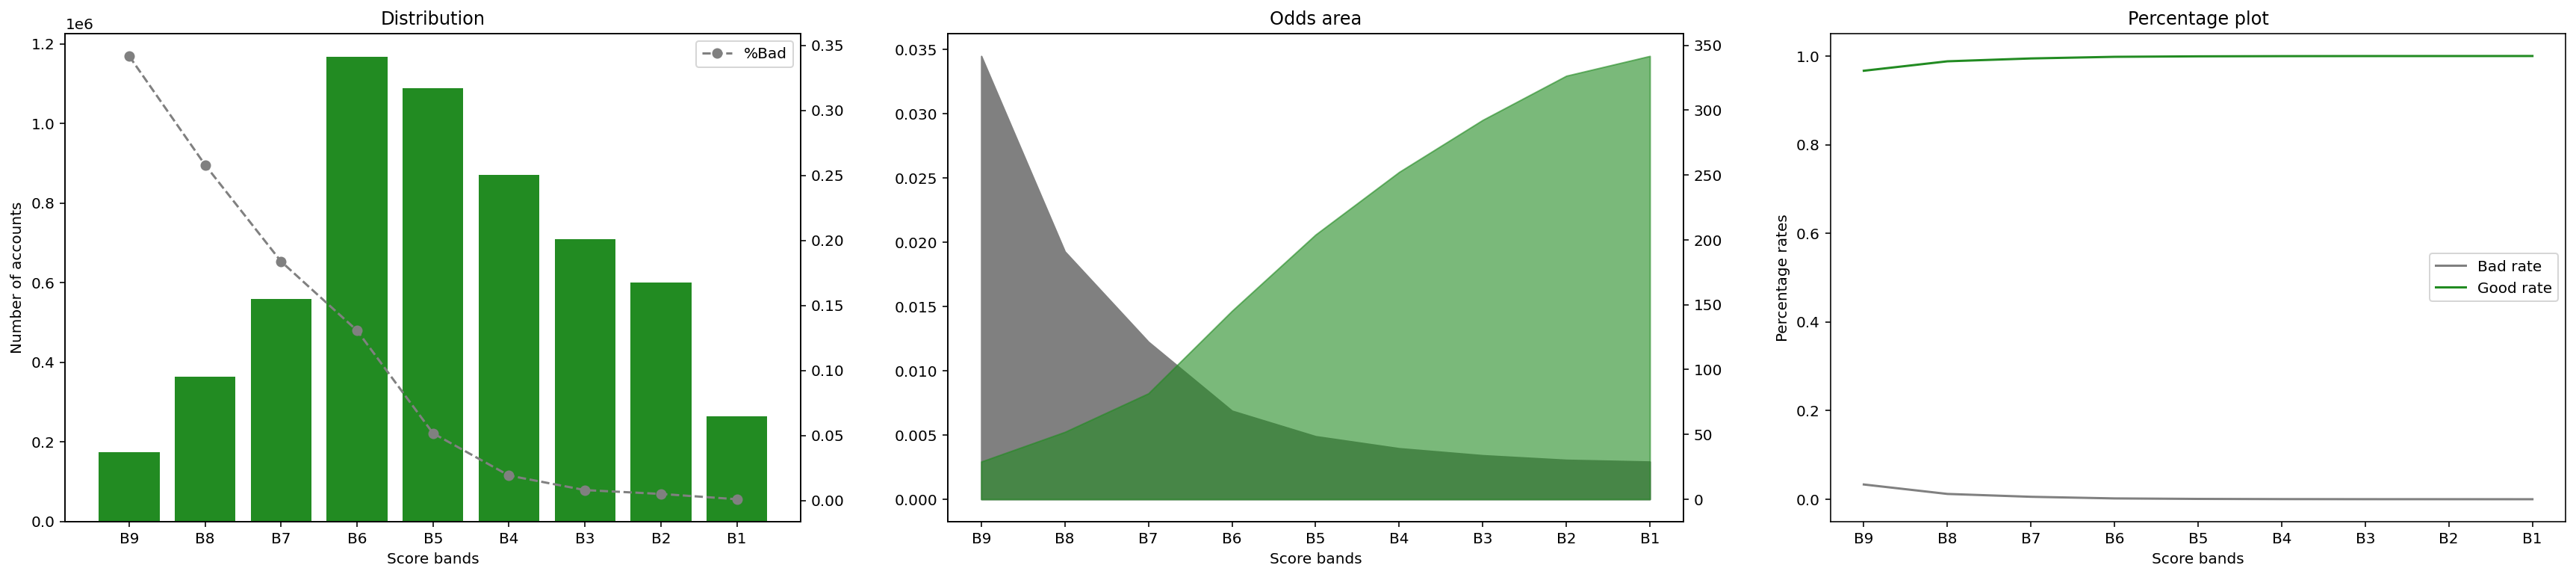

In [7]:
# Other plots
fig, axs = plt.subplots(1, 3, figsize = (30, 6))
axs = axs.ravel()

# Distribution
axs[0].set_title('Distribution')
axs[0].bar(
    range(classDevResult.shape[0]),
    classDevResult['N'],
    color = 'forestgreen'
)
axs[0].set_xticks(range(classDevResult.shape[0]))
axs[0].set_xticklabels(classDevResult['Band'])
axs[0].set(xlabel = 'Score bands', ylabel = 'Number of accounts')
axs[0] = axs[0].twinx()
axs[0].plot(
    range(classDevResult.shape[0]),
    classDevResult['%Bad'],
    c = 'gray',
    linestyle = '--',
    marker = 'o',
    label = '%Bad'
)
axs[0].legend(frameon = True, facecolor = 'white')

# Odds
axs[1].set_title('Odds area')
axs[1].set(xlabel = 'Score bands', ylabel = '')
axs[1].fill_between(
    range(classDevResult.shape[0]),
    classDevResult['BGOdds'],
    color = 'gray',
    interpolate = True
)
axs[1].set_xticks(range(classDevResult.shape[0]))
axs[1].set_xticklabels(classDevResult['Band'])
axs[1] = axs[1].twinx()
axs[1].fill_between(
    range(classDevResult.shape[0]),
    classDevResult['GBOdds'],
    color = 'forestgreen',
    alpha = 0.6
)

# Percentage
axs[2].set_title('Percentage plot')
axs[2].set(xlabel = 'Score bands', ylabel = 'Percentage rates')
axs[2].plot(
    range(classDevResult.shape[0]),
    classDevResult['badRate'],
    c = 'gray',
    label = 'Bad rate'
)
axs[2].plot(
    range(classDevResult.shape[0]),
    classDevResult['goodRate'],
    c = 'forestgreen',
    label = 'Good rate'
)
axs[2].set_xticks(range(classDevResult.shape[0]))
axs[2].set_xticklabels(classDevResult['Band'])
axs[2].legend(frameon = True, facecolor = 'white')
plt.show()

In [8]:
# Import final factors development
factorDev = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/creditrisk/main/datasets/factorDevelopment.csv'
)

# Show
factorDev.head(5)

,Variable,Bin,N,Bad
0,A,1,4522324,7681
1,A,2,774007,2941
2,A,3,501583,6292
3,B,1,4244180,4968
4,B,2,1341768,6658


## Model driver accuracy
The measures prescribed here assess the predictive prowess of the factors that comprise the scorecard. While these measures are also computed at the stage of building the scorecard, computation with a validation sample will ensure that they continue to be individually predictive, and thus, worthy of continued inclusion in the scorecard.

### Log odds analysis (WOE)
The Log odds measure is computed to assess the trend of the predictive power of the individual scorecard drivers to discriminate between risky and non-risky customers. It uses the distribution of bad and good within the categories of the individual scorecard drivers to compute the value.
Given n categories of the driver for which the Log odds are being calculated, the Log odds for each bin are computed as:

\begin{align}
        \text{WOE} = ln(\frac{\text{%Good}}{\text{%Bad}})
    \end{align}

### Information Value (IV)
The IV is computed to assess the effectiveness of the individual scorecard drivers to discriminate between risky and non-risky customers. It uses the distribution of bad and good within the categories of the individual scorecard drivers to compute the value.

\begin{align}
        \text{IV} = \sum_{i = 1}^{n}\Bigg\{\big(\text{%Good}_{i} - \text{%Bad}_{i}\big) * WOE\Bigg\}
    \end{align}

In [9]:
# Define function model driver accuracy
# Odds analysis
def oddsAnalysis(df):
  table = df.copy()
  table = table.sort_values(by = ['Variable', 'Bin'])
  badRate = list(table['Bad'] / table['N'])
  table['Good'] = table['N'] - table['Bad']
  table = table.groupby(
      ['Variable', 'Bin']
  ).sum() / \
  table.groupby(
      ['Variable']
  ).sum().drop(
      ['Bin'],
      axis = 1
  )
  table['WOE'] = np.log(table['Good'] / table['Bad'])
  table['IV'] = table['WOE'] * (table['Good'] - table['Bad'])
  table['badRate'] = badRate
  return table.reset_index()

# IV
def IV(df):
  return df.groupby(['Variable'], as_index = False)['IV'].sum()

# Apply function
oddsDevResult = oddsAnalysis(factorDev)
oddsDevResult.head(5)

,Variable,Bin,N,Bad,Good,WOE,IV,badRate
0,A,1,0.779992,0.454121,0.780945,0.542141,0.177185,0.001698
1,A,2,0.133497,0.173880,0.133379,-0.265166,0.010739,0.003800
2,A,3,0.086511,0.372000,0.085676,-1.468324,0.420416,0.012544
3,B,1,0.732018,0.293721,0.733301,0.914925,0.402182,0.001171
4,B,2,0.231423,0.393638,0.230948,-0.533240,0.086753,0.004962


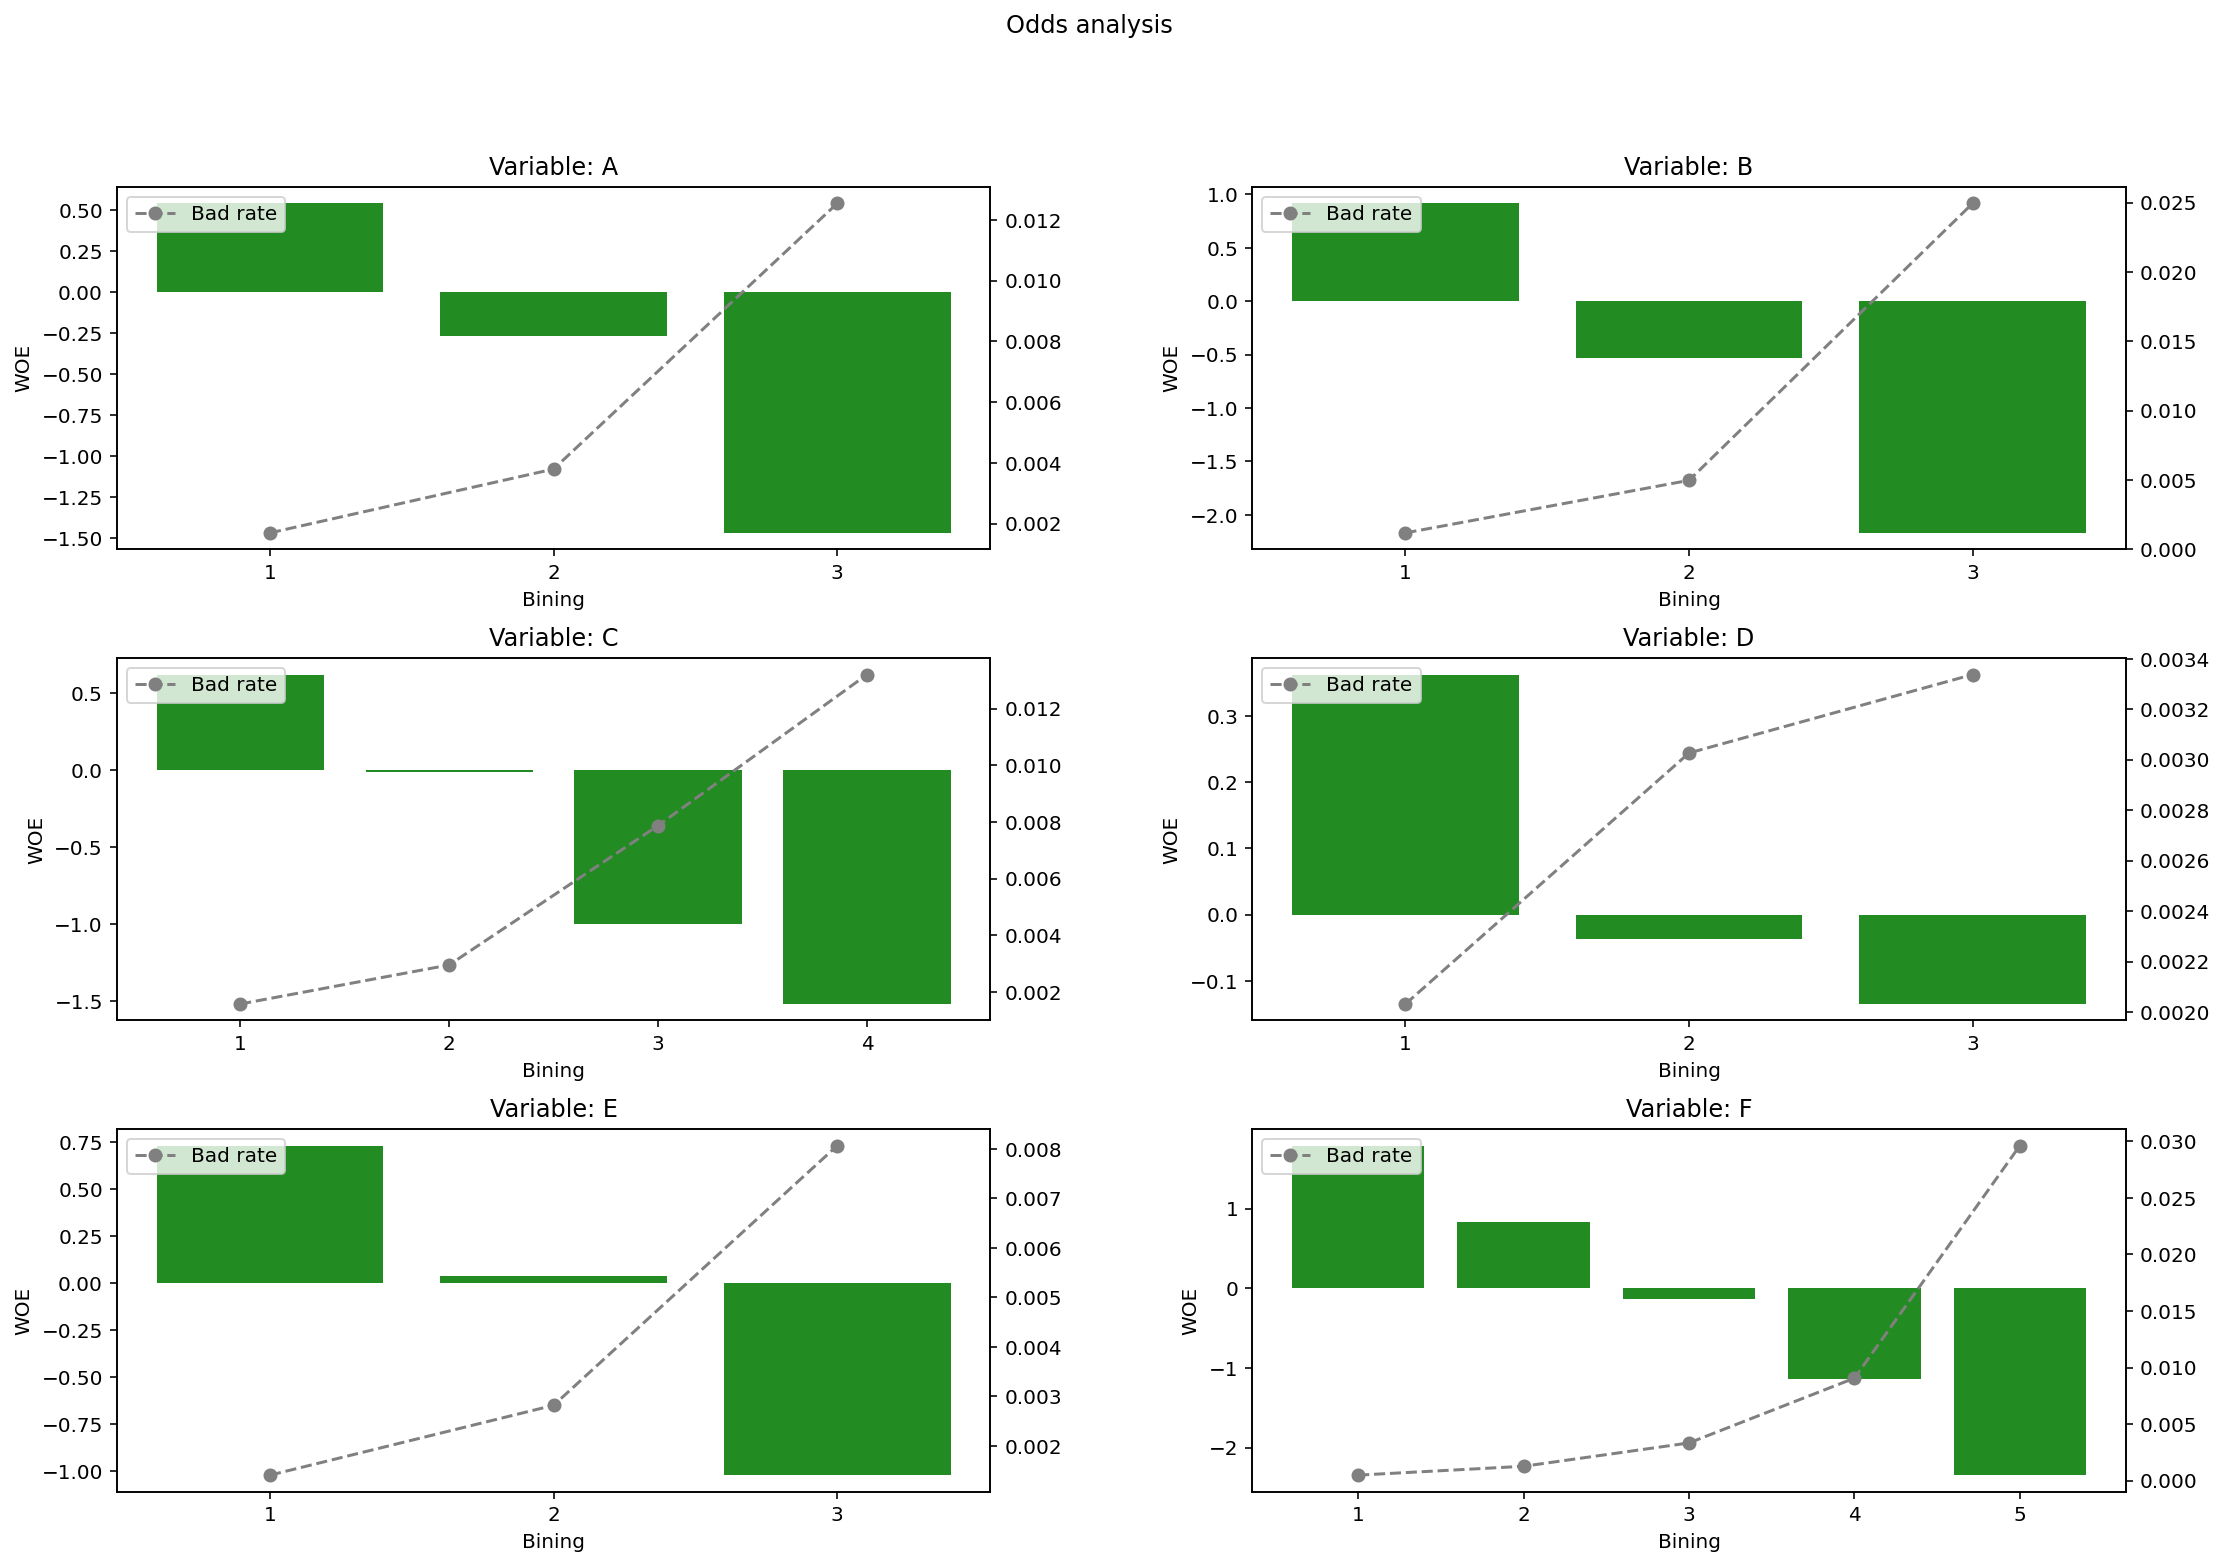

In [10]:
# Plot
# Odds analysis
fig, axs = plt.subplots(3, 2, figsize = (18, 12))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
fig.suptitle('Odds analysis')
axs = axs.ravel()
for i, var in enumerate(np.unique(oddsDevResult['Variable'])):
  dataPlot = oddsDevResult.query(
      "Variable == @var"
  )[['Bin', 'WOE', 'badRate']]
  axs[i].bar(
      range(dataPlot.shape[0]),
      dataPlot['WOE'],
      color = 'forestgreen'
  )
  axs[i].set_xticks(range(dataPlot.shape[0]))
  axs[i].set_xticklabels(dataPlot['Bin'])
  axs[i].set_title(f'Variable: {var}')
  axs[i].set(xlabel = 'Bining', ylabel = 'WOE')
  axs[i] = axs[i].twinx()
  axs[i].plot(
      range(dataPlot.shape[0]),
      dataPlot['badRate'],
      c = 'gray',
      linestyle = '--',
      marker = 'o',
      label = 'Bad rate'
  )
  axs[i].legend(frameon = True, facecolor = 'white')
plt.show()

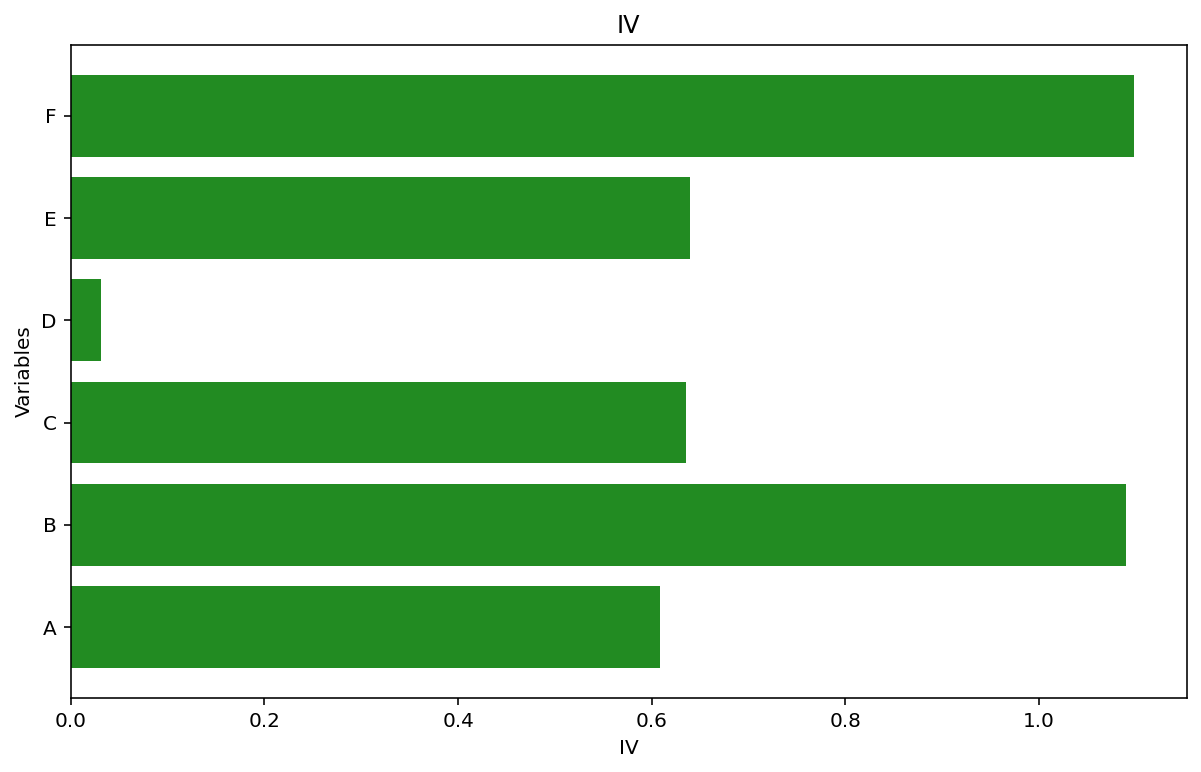

In [11]:
# Plot
# IV
IVDevResult = IV(oddsDevResult)

plt.figure(figsize = (10, 6))
plt.barh(
    IVDevResult.index,
    IVDevResult['IV'],
    color = 'forestgreen'
)
plt.title('IV')
plt.yticks(
    IVDevResult.index,
    IVDevResult['Variable']
)
plt.xlabel('IV')
plt.ylabel('Variables')
plt.show()

In [12]:
# Import score validation
scoreVal = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/creditrisk/main/datasets/scoreValidation.csv'
)

# Show
scoreVal

,Band,N,Bad
0,B9,102115,5936
1,B8,255195,5541
2,B7,397493,4300
3,B6,818480,3739
4,B5,829249,2226
5,B4,584136,1138
6,B3,406596,544
7,B2,396638,391
8,B1,168201,84


## Model stability
It is possible that the distribution of the individual model drivers may significantly change for a future sample of data points, thus rendering the model unsuitable for further use upon this future population. It is imperative to establish that the distribution of the individual model risk drivers as well as the model outputs have not significantly changed for the population upon which the models will be deployed.

### PSI
The model stability over portfolio level.

\begin{align}
        \text{PSI} = \sum_{i = 1}^{n}\Bigg\{\big(\text{%N_Validation}_{i} - \text{%N_Development}_{i}\big) * \big(ln(\frac{\text{%N_Validation}_{i}}{\text{%N_Development}_{i}})\big)\Bigg\}
    \end{align}


### CSI
The model stability over each model driver.

\begin{align}
        \text{CSI} = \sum_{i = 1}^{n}\Bigg\{\big(\text{%N_Validation}_{factor, i} - \text{%N_Development}_{factor, i}\big) * \big(ln(\frac{\text{%N_Validation}_{factor, i}}{\text{%N_Development}_{factor, i}})\big)\Bigg\}
    \end{align}


In [13]:
# Define function model stability (PSI)
def PSI(df1, df2):
  valTime = df1['N'] / df1['N'].sum()
  inTime = df2['N'] / df2['N'].sum()
  result = (valTime - inTime) * np.log(
      valTime / inTime
  )
  return np.sum(result)

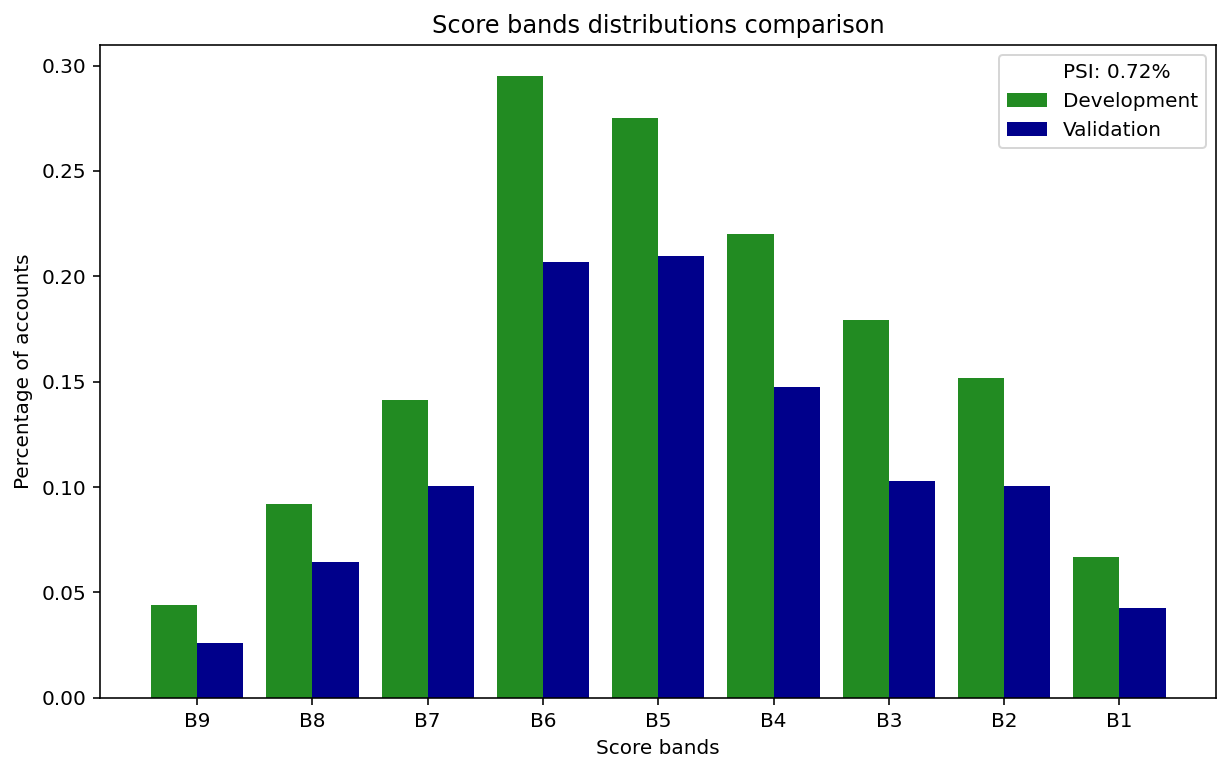

In [14]:
# Plot
# PSI
PSIResult = PSI(scoreVal, scoreDev)

plt.figure(figsize = (10, 6))
plt.title('Score bands distributions comparison')
plt.xlabel('Score bands')
plt.ylabel('Percentage of accounts')
plt.bar(
    np.arange(scoreDev.shape[0]) - 0.4 / 2,
    scoreDev['N'] / scoreVal['N'].sum(),
    0.4,
    color = 'forestgreen',
    label = 'Development'
)
plt.bar(
    np.arange(scoreVal.shape[0]) + 0.4 / 2,
    scoreVal['N'] / scoreVal['N'].sum(),
    0.4,
    color = 'darkblue',
    label = 'Validation'
)
plt.plot([], [], ' ', label = f'PSI: {PSIResult * 100:.2f}%')
plt.xticks(
    np.arange(scoreDev.shape[0]),
    scoreDev['Band']
)
plt.legend(frameon = True, facecolor = 'white')
plt.show()

In [15]:
# Import final factors validation
factorVal = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/creditrisk/main/datasets/factorValidation.csv'
)

# Show
factorVal.head(5)

,Variable,Bin,N,Bad
0,A,1,3184285,13380
1,A,2,497051,3408
2,A,3,276843,7111
3,B,1,2841461,7957
4,B,2,986414,9906


In [16]:
# Define function model stability (CSI)
def CSI(df1, df2):
  valTime = df1.copy()
  inTime = df2.copy()
  valTime = valTime.groupby(
      ['Variable', 'Bin']
  ).sum() / \
  valTime.groupby(
      ['Variable']
  ).sum().drop(
      ['Bin'],
      axis = 1
  )
  valTime = valTime['N'].rename('%Validation')
  inTime = inTime.groupby(
      ['Variable', 'Bin']
  ).sum() / \
  inTime.groupby(
      ['Variable']
  ).sum().drop(
      ['Bin'],
      axis = 1
  )
  inTime = inTime['N'].rename('%Development')
  result = pd.concat([valTime, inTime], axis = 1)
  result['CSI'] = (result['%Validation'] - result['%Development']) * \
                  np.log(result['%Validation'] / result['%Development'])
  return result.reset_index()

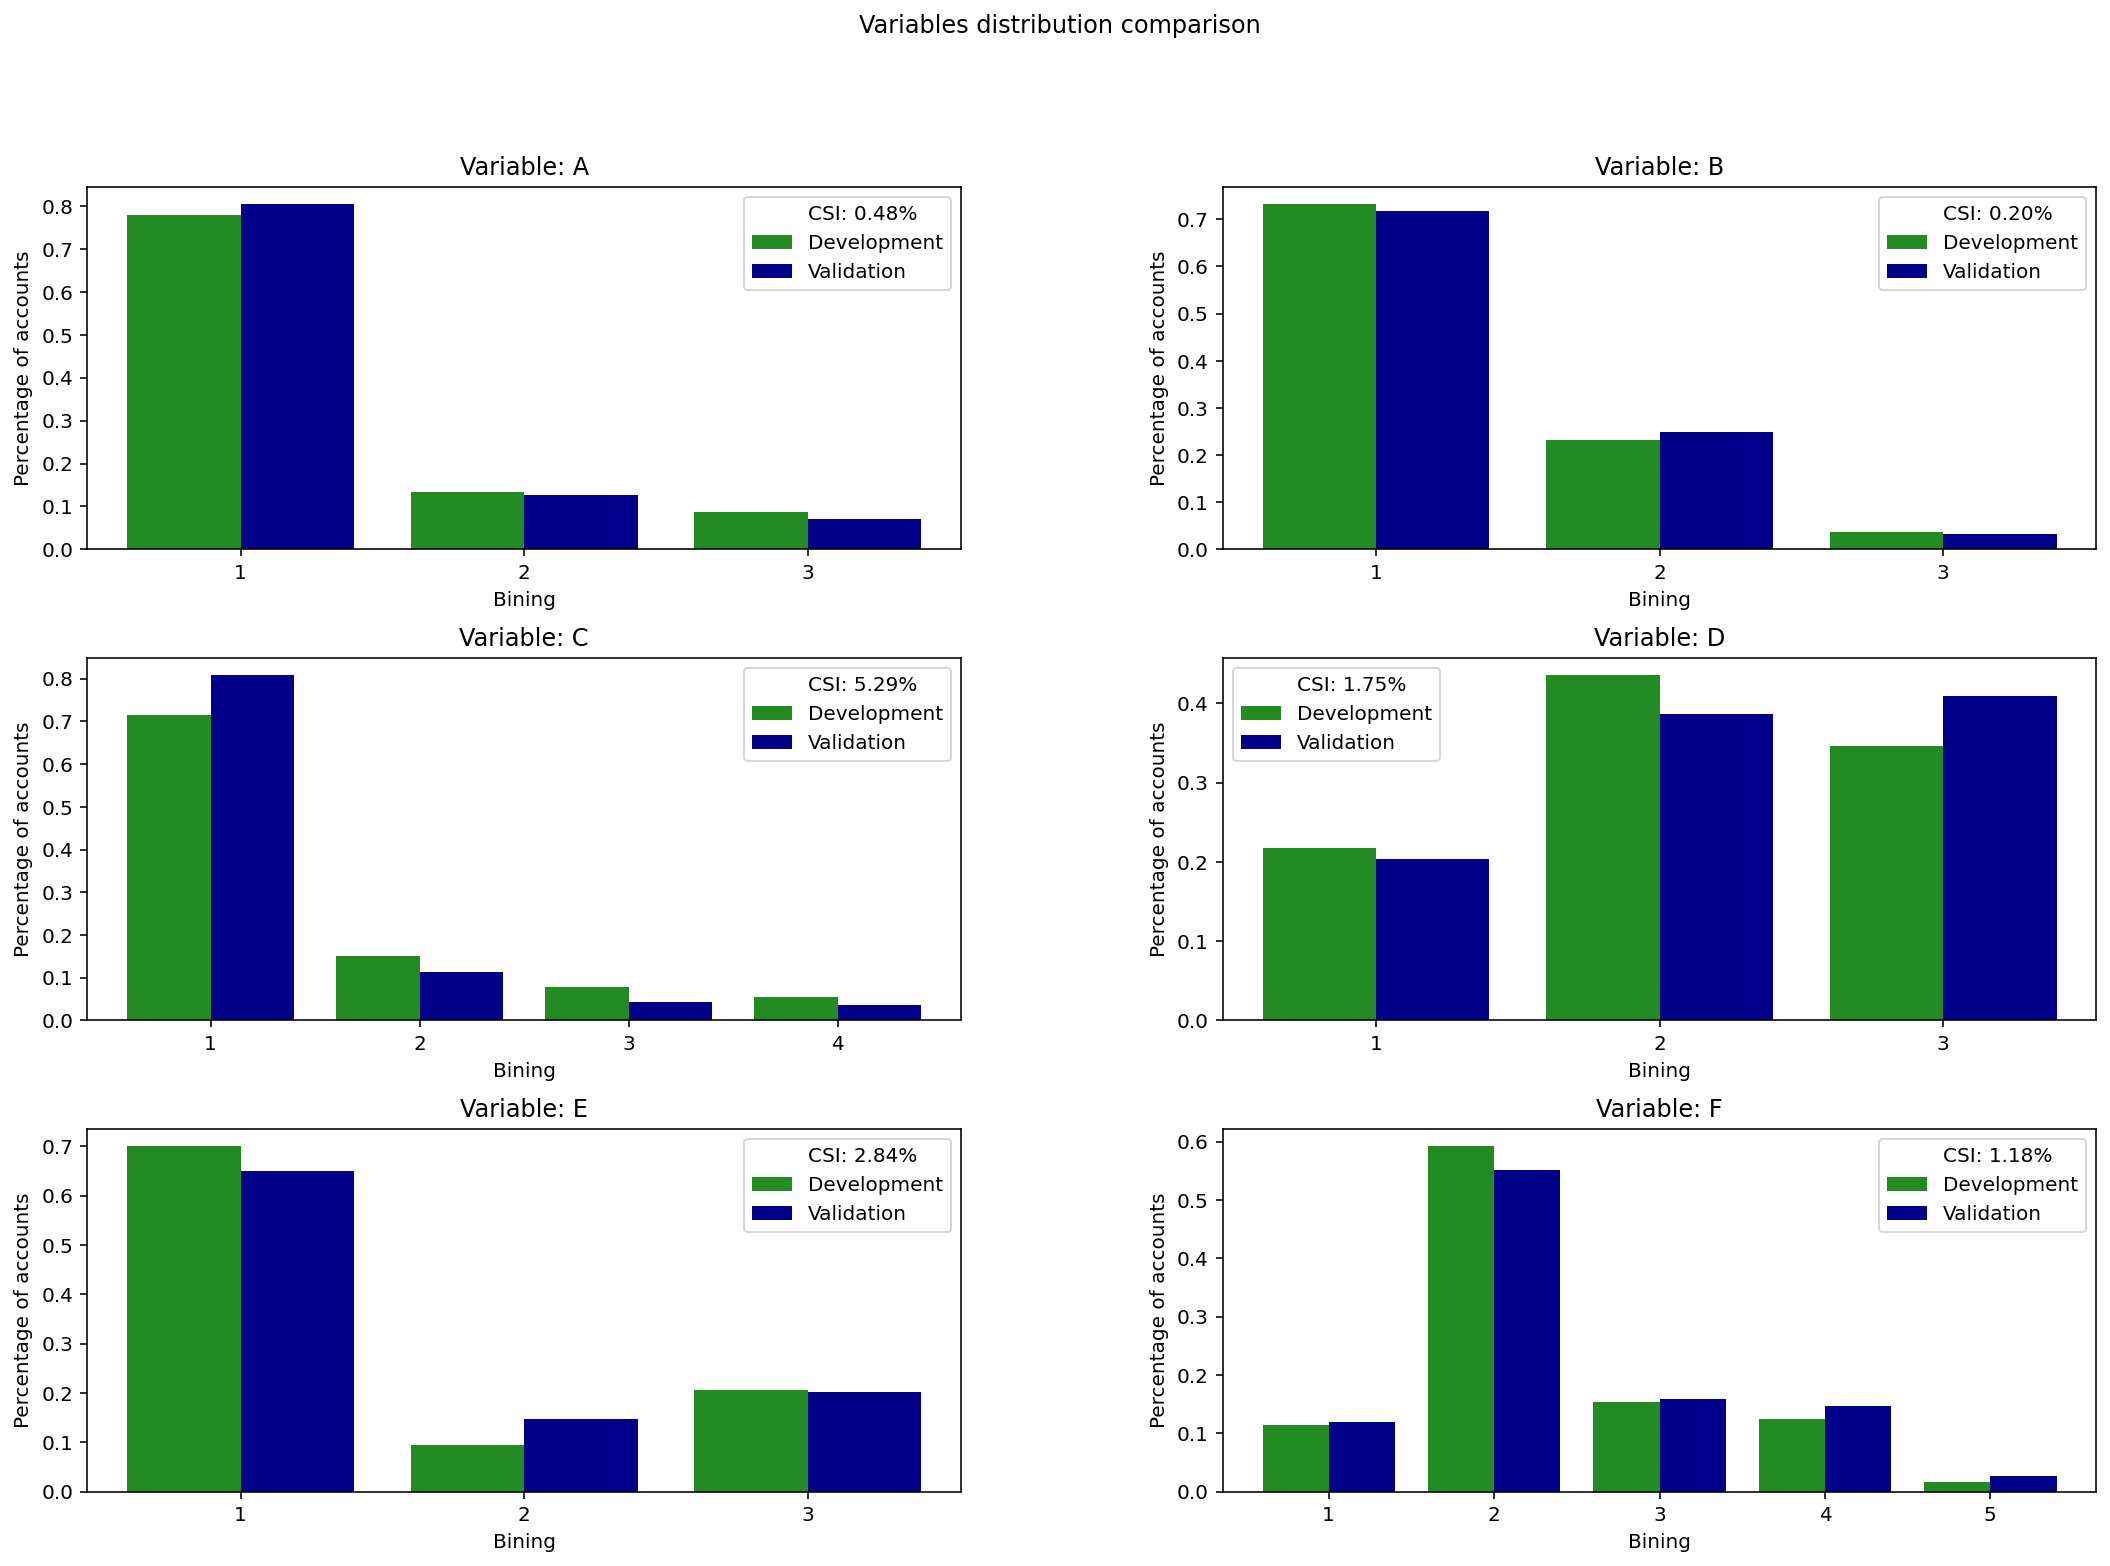

In [17]:
# Plot
# CSI
CSITable = CSI(factorVal, factorDev)
CSIResult = CSITable.groupby(['Variable'])['CSI'].sum()

fig, axs = plt.subplots(3, 2, figsize = (18, 12))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
fig.suptitle('Variables distribution comparison')
axs = axs.ravel()
for i, var in enumerate(CSIResult.index):
  dataPlot = CSITable.query(
      "Variable == @var"
  )[['Bin', '%Validation', '%Development']]
  axs[i].bar(
      np.arange(dataPlot.shape[0]) - 0.4 / 2,
      dataPlot['%Development'],
      0.4,
      color = 'forestgreen',
      label = 'Development'
  )
  axs[i].bar(
      np.arange(dataPlot.shape[0]) + 0.4 / 2,
      dataPlot['%Validation'],
      0.4,
      color = 'darkblue',
      label = 'Validation'
  )
  axs[i].plot([], [], ' ', label = f'CSI: {CSIResult[i] * 100:.2f}%')
  axs[i].set_xticks(range(dataPlot.shape[0]))
  axs[i].set_xticklabels(dataPlot['Bin'])
  axs[i].set_title(f'Variable: {var}')
  axs[i].set(xlabel = 'Bining', ylabel = 'Percentage of accounts')
  axs[i].legend(frameon = True, facecolor = 'white')
plt.show()

### Validation period

In [18]:
# Apply classfication with data from validation period
classValResult = modelClass(scoreVal)
classValResult

,Band,N,Bad,Good,badRate,goodRate,%Bad,%Good,cumBadFreq,cumGoodFreq,BGOdds,GBOdds,cumBad,cumGood,ROC,KS
0,B9,102115,5936,96179,0.058131,0.941869,0.248379,0.024447,0.248379,0.024447,0.061718,16.202662,0.248379,0.024447,0.003036,0.223932
1,B8,255195,5541,249654,0.021713,0.978287,0.231851,0.063457,0.480229,0.087904,0.033187,30.132700,0.480229,0.087904,0.023118,0.392325
2,B7,397493,4300,393193,0.010818,0.989182,0.179924,0.099942,0.660153,0.187846,0.021348,46.841985,0.660153,0.187846,0.056986,0.472307
3,B6,818480,3739,814741,0.004568,0.995432,0.156450,0.207092,0.816603,0.394938,0.012560,79.615034,0.816603,0.394938,0.152912,0.421665
4,B5,829249,2226,827023,0.002684,0.997316,0.093142,0.210214,0.909745,0.605152,0.009132,109.501886,0.909745,0.605152,0.181451,0.304594
5,B4,584136,1138,582998,0.001948,0.998052,0.047617,0.148187,0.957362,0.753339,0.007720,129.536189,0.957362,0.753339,0.138341,0.204024
6,B3,406596,544,406052,0.001338,0.998662,0.022762,0.103211,0.980125,0.856549,0.006951,143.862705,0.980125,0.856549,0.099985,0.123575
7,B2,396638,391,396247,0.000986,0.999014,0.016361,0.100718,0.996485,0.957268,0.006324,158.139282,0.996485,0.957268,0.099541,0.039217
8,B1,168201,84,168117,0.000499,0.999501,0.003515,0.042732,1.000000,1.000000,0.006075,164.617934,1.000000,1.000000,0.042657,0.000000


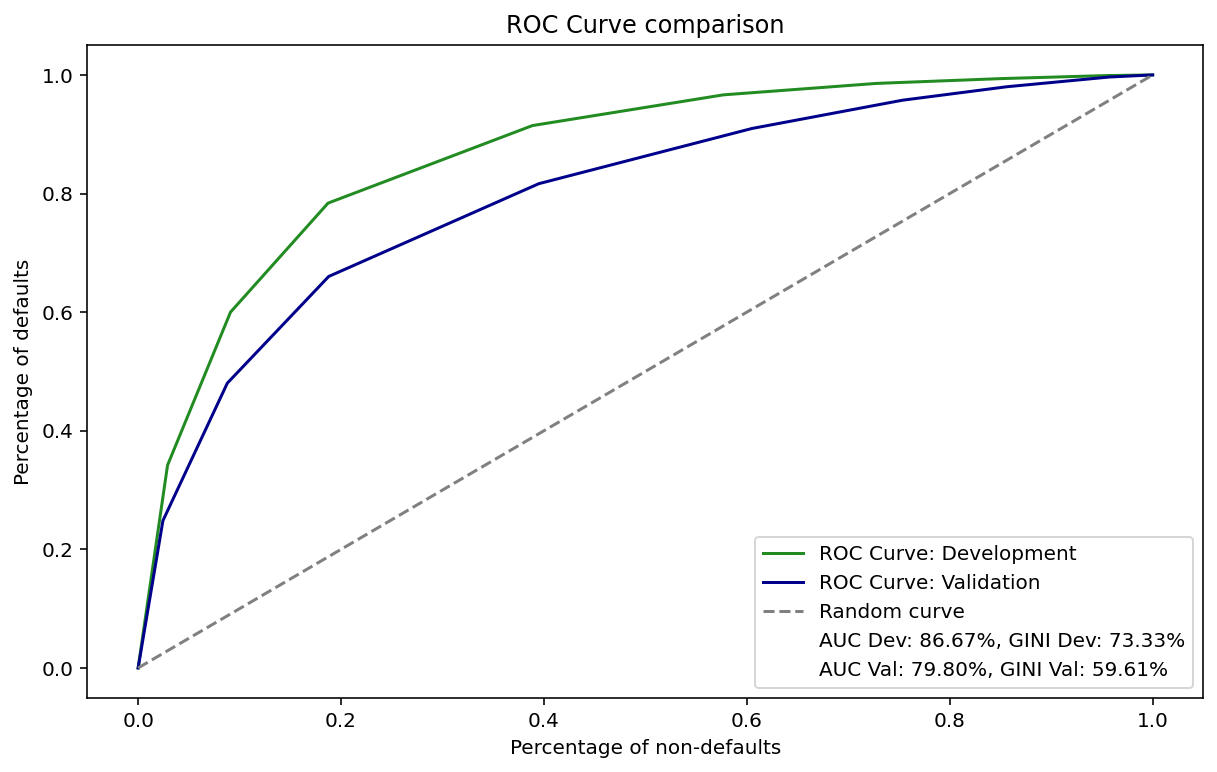

In [19]:
# Classification ability (Validation)
AUCVal = classValResult['ROC'].sum()
GINIVal = AUCVal * 2 - 1
KSVal = classValResult['KS'].max()

# Plot
# ROC (Validation)
plt.figure(figsize = (10, 6))
plt.plot(
    np.hstack((0, classDevResult['cumGood'])),
    np.hstack((0, classDevResult['cumBad'])),
    c = 'forestgreen',
    label = 'ROC Curve: Development'
)
plt.plot(
    np.hstack((0, classValResult['cumGood'])),
    np.hstack((0, classValResult['cumBad'])),
    c = 'darkblue',
    label = 'ROC Curve: Validation'
)
plt.plot(
    [0, 1],
    [0, 1],
    c = 'gray',
    linestyle = '--',
    label = 'Random curve'
)
plt.plot([], [], ' ', label = f'AUC Dev: {AUC * 100:.2f}%, GINI Dev: {GINI * 100:.2f}%')
plt.plot([], [], ' ', label = f'AUC Val: {AUCVal * 100:.2f}%, GINI Val: {GINIVal * 100:.2f}%')
plt.title('ROC Curve comparison')
plt.xlabel('Percentage of non-defaults')
plt.ylabel('Percentage of defaults')
plt.legend(frameon = True, facecolor = 'white')
plt.show()

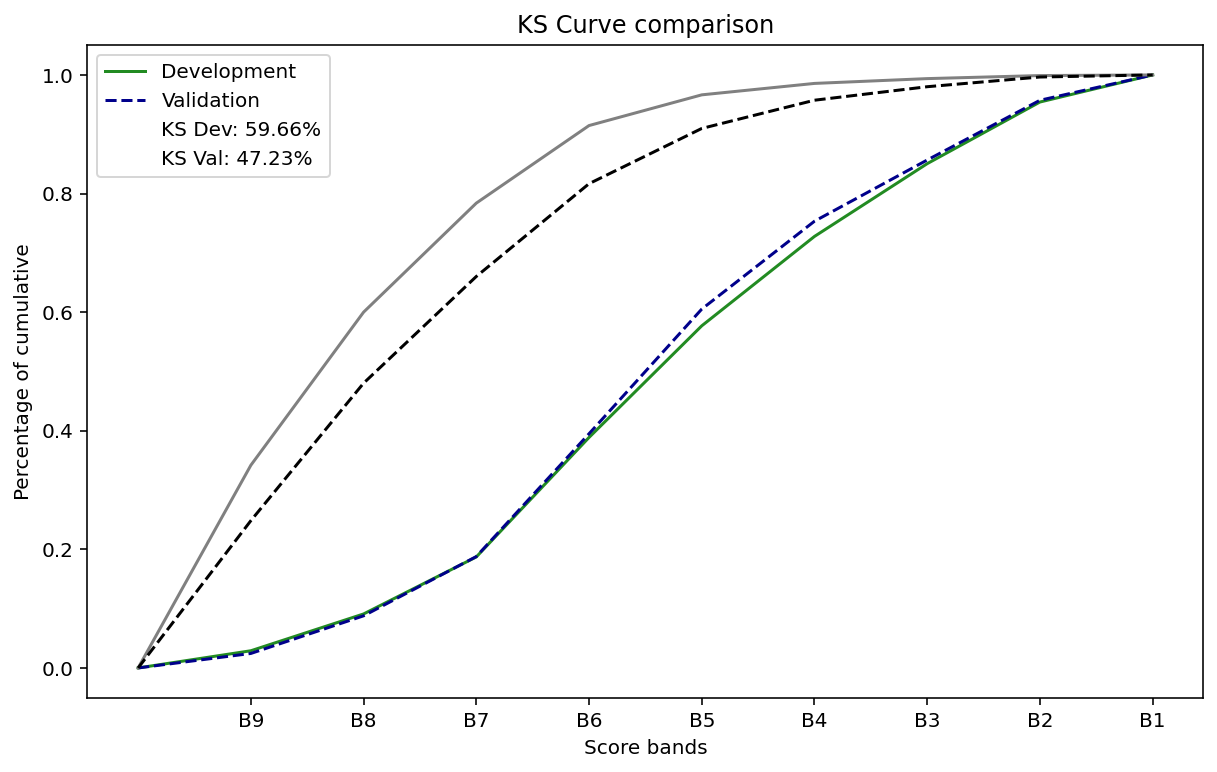

In [20]:
# Plot
# KS (Validation)
plt.figure(figsize = (10, 6))
plt.plot(
    np.hstack((0, classDevResult['cumGood'])),
    c = 'forestgreen',
    label = 'Development'
)
plt.plot(
    np.hstack((0, classValResult['cumGood'])),
    c = 'darkblue',
    label = 'Validation',
    linestyle = '--'
)
plt.plot(
    np.hstack((0, classDevResult['cumBad'])),
    c = 'gray',
)
plt.plot(
    np.hstack((0, classValResult['cumBad'])),
    c = 'black',
    linestyle = '--'
)
plt.plot([], [], ' ', label = f'KS Dev: {KS * 100:.2f}%')
plt.plot([], [], ' ', label = f'KS Val: {KSVal * 100:.2f}%')
plt.title('KS Curve comparison')
plt.xticks(
    np.arange(1, classDevResult.shape[0] + 1),
    classDevResult['Band']
)
plt.xlabel('Score bands')
plt.ylabel('Percentage of cumulative')
plt.legend(frameon = True, facecolor = 'white')
plt.show()

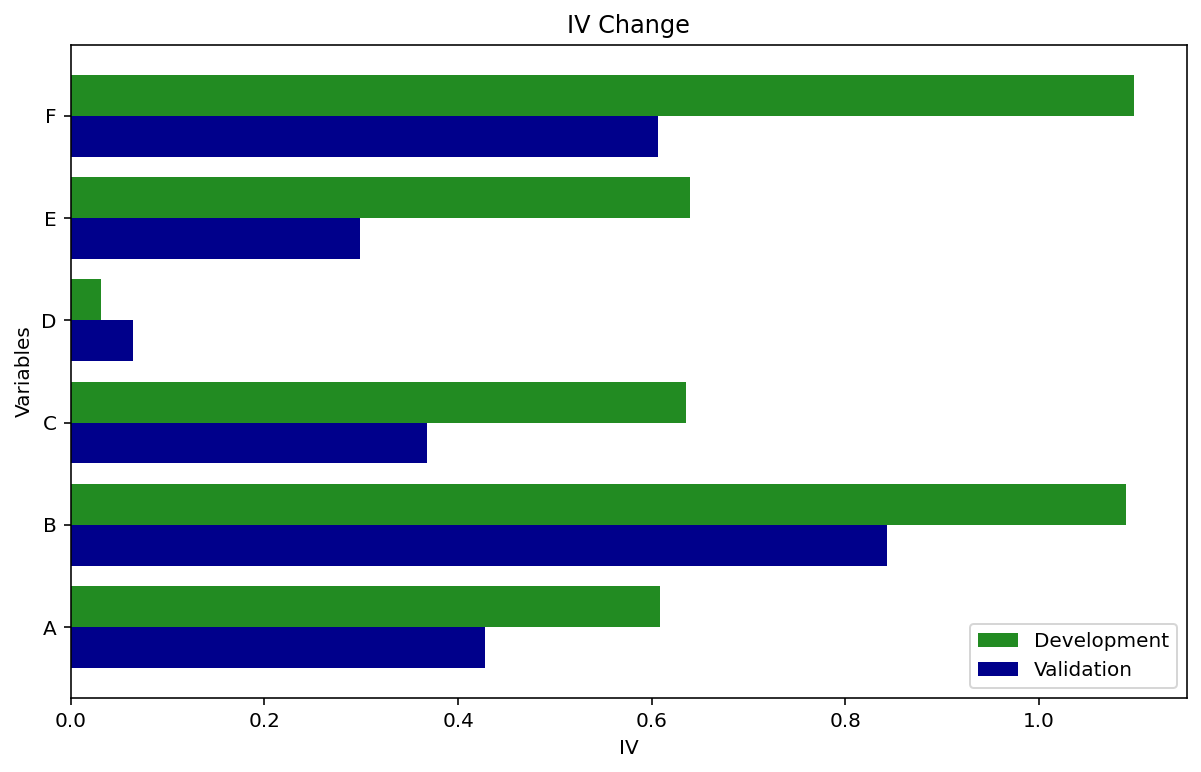

In [21]:
# IV Change 
# Validation period
IVValResult = IV(oddsAnalysis(factorVal)) #Call odds function before IV Function
IVChange = (IVValResult['IV'] / IVDevResult['IV']) - 1 #Change in IV

# Plot
plt.figure(figsize = (10, 6))
ax = plt.barh(
    IVDevResult.index + 0.4 / 2,
    IVDevResult['IV'],
    0.4,
    color = 'forestgreen',
    label = 'Development'
)
ax = plt.barh(
    IVValResult.index - 0.4 / 2,
    IVValResult['IV'],
    0.4,
    color = 'darkblue',
    label = 'Validation'
)
plt.title('IV Change')
plt.yticks(
    IVDevResult.index,
    IVDevResult['Variable']
)
plt.xlabel('IV')
plt.ylabel('Variables')
plt.legend(frameon = True, facecolor = 'white')
plt.show()

In [22]:
# IV Change result
IVChangeResult = pd.DataFrame(
    IVChange
).rename(
    columns = {'IV': 'IV Changed'}
)
IVChangeResult.index = IVValResult['Variable']
IVChangeResult

,IV Changed
Variable,
A,-0.296474
B,-0.225714
C,-0.420666
D,1.040320
E,-0.532402
F,-0.447790
